<a href="https://colab.research.google.com/github/SherKhan3210/PortfolioProjects/blob/main/sales_forecast.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [107]:
import os

In [108]:
# Import Packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from keras.models import Sequential
from keras.layers import Dense, LSTM
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [109]:
# Import Data
store_sales = pd.read_csv("sales_forecast_data.csv")
store_sales.head(10)

,date,store,item,sales
0,1/1/2013,1,1,13
1,1/2/2013,1,1,11
2,1/3/2013,1,1,14
3,1/4/2013,1,1,13
4,1/5/2013,1,1,10
5,1/6/2013,1,1,12
6,1/7/2013,1,1,10
7,1/8/2013,1,1,9
8,1/9/2013,1,1,12
9,1/10/2013,1,1,9


In [110]:
store_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913000 entries, 0 to 912999
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   date    913000 non-null  object
 1   store   913000 non-null  int64 
 2   item    913000 non-null  int64 
 3   sales   913000 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 27.9+ MB


In [111]:
# Drop store and item columns
store_sales = store_sales.drop(['store','item'],axis = 1)

In [112]:
store_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913000 entries, 0 to 912999
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   date    913000 non-null  object
 1   sales   913000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 13.9+ MB


In [113]:
# Covert date from object to dateTime datatype
store_sales['date'] = pd.to_datetime(store_sales['date'])

In [114]:
store_sales.info()
store_sales.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913000 entries, 0 to 912999
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   date    913000 non-null  datetime64[ns]
 1   sales   913000 non-null  int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 13.9 MB


,date,sales
0,2013-01-01,13
1,2013-01-02,11
2,2013-01-03,14
3,2013-01-04,13
4,2013-01-05,10
5,2013-01-06,12
6,2013-01-07,10
7,2013-01-08,9
8,2013-01-09,12
9,2013-01-10,9


In [115]:
# Convert date to a month period, then sum number of items in
# each month

store_sales['date'] = store_sales['date'].dt.to_period("M")
monthly_sales = store_sales.groupby('date').sum().reset_index()

In [116]:
# convert resulting date column to timestamp datatype
monthly_sales['date'] = monthly_sales['date'].dt.to_timestamp()

In [117]:
monthly_sales.head(12)

,date,sales
0,2013-01-01,454904
1,2013-02-01,459417
2,2013-03-01,617382
3,2013-04-01,682274
4,2013-05-01,763242
5,2013-06-01,795597
6,2013-07-01,855922
7,2013-08-01,766761
8,2013-09-01,689907
9,2013-10-01,656587


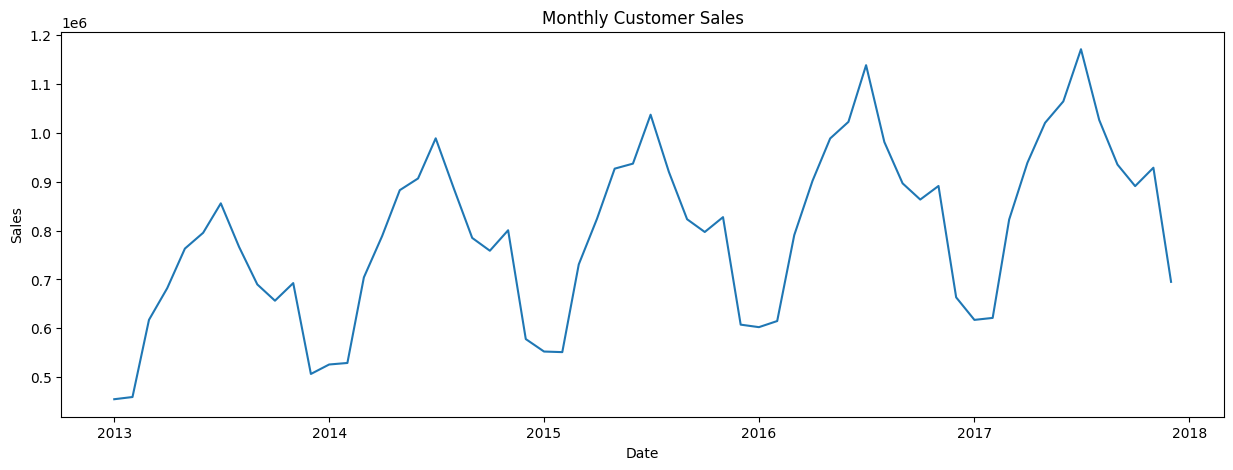

In [118]:
# Visualization
plt.figure(figsize=(15,5))
plt.plot(monthly_sales['date'],monthly_sales['sales'])
plt.xlabel("Date")
plt.ylabel("Sales")
plt.title("Monthly Customer Sales")
plt.show()

In [119]:
monthly_sales['sales_diff'] = monthly_sales['sales'].diff()
monthly_sales = monthly_sales.dropna()
monthly_sales.head(10)

,date,sales,sales_diff
1,2013-02-01,459417,4513.0
2,2013-03-01,617382,157965.0
3,2013-04-01,682274,64892.0
4,2013-05-01,763242,80968.0
5,2013-06-01,795597,32355.0
6,2013-07-01,855922,60325.0
7,2013-08-01,766761,-89161.0
8,2013-09-01,689907,-76854.0
9,2013-10-01,656587,-33320.0
10,2013-11-01,692643,36056.0


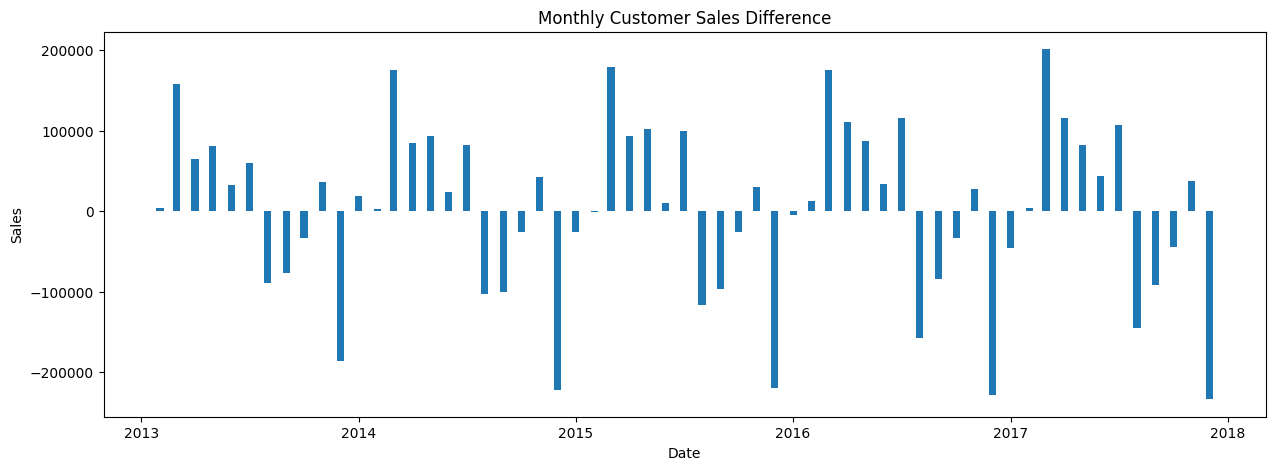

In [120]:
plt.figure(figsize=(15,5))
plt.bar(monthly_sales['date'],monthly_sales['sales_diff'],width=12)
plt.xlabel("Date")
plt.ylabel("Sales")
plt.title("Monthly Customer Sales Difference")
plt.show()

In [121]:
# Dropping off sales and date
supervised_data = monthly_sales.drop(['date','sales'],axis=1)

In [122]:
# Preparing supervised data
for i in range(1,13):
  col_name = 'month_'+str(i)
  supervised_data[col_name] = supervised_data['sales_diff'].shift(i)
supervised_data = supervised_data.dropna().reset_index(drop=True)
supervised_data.head(10)

,sales_diff,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0,32355.0,80968.0,64892.0,157965.0,4513.0
1,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0,32355.0,80968.0,64892.0,157965.0
2,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0,32355.0,80968.0,64892.0
3,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0,32355.0,80968.0
4,23965.0,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0,32355.0
5,82168.0,23965.0,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0
6,-103414.0,82168.0,23965.0,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0
7,-100472.0,-103414.0,82168.0,23965.0,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0
8,-26241.0,-100472.0,-103414.0,82168.0,23965.0,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0
9,41900.0,-26241.0,-100472.0,-103414.0,82168.0,23965.0,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0


In [123]:
# Split data into train and test data
train_data = supervised_data[:-12]
test_data = supervised_data[-12:]
print("Train Data Shape: ", train_data.shape)
print("Test Data Shape: ", test_data.shape)

Train Data Shape:  (35, 13)
Test Data Shape:  (12, 13)


In [124]:
scaler = MinMaxScaler(feature_range=(-1,1))
scaler.fit(train_data)
train_data = scaler.transform(train_data)
test_data = scaler.transform(test_data)

In [125]:
x_train,y_train = train_data[:,1:], train_data[:,0:1]
x_test,y_test = test_data[:,1:], test_data[:,0:1]
y_train = y_train.ravel()
y_test = y_test.ravel()
print("x_train Shape:", x_train.shape)
print("y_train Shape:", y_train.shape)
print("x_test Shape:", x_test.shape)
print("y_test Shape:", y_test.shape)

x_train Shape: (35, 12)
y_train Shape: (35,)
x_test Shape: (12, 12)
y_test Shape: (12,)


In [126]:
# Make prediction data frame to merge the predicted sales prices of all
# trained algorithms
sales_dates = monthly_sales['date'][-12:].reset_index(drop=True)
predict_df = pd.DataFrame(sales_dates)

In [127]:
act_sales = monthly_sales['sales'][-13:].to_list()
print(act_sales)

[663411, 617306, 621369, 822667, 938862, 1020686, 1064624, 1171393, 1026403, 935263, 891160, 928837, 695170]


In [128]:
# Createe the linear regression model and predicted output
lr_model = LinearRegression()
lr_model.fit(x_train,y_train)
lr_pre = lr_model.predict(x_test)

In [129]:
lr_pre = lr_pre.reshape(-1,1)
# set matrix - contains the input features of the test data, and
# also the predicted output
lr_pre_test_set = np.concatenate([lr_pre,x_test],axis=1)
lr_pre_test_set = scaler.inverse_transform(lr_pre_test_set)

In [130]:
result_list =[]
for index in range(0,len(lr_pre_test_set)):
  result_list.append(lr_pre_test_set[index][0] + act_sales[index])
lr_pre_series = pd.Series(result_list,name="Linear Prediction")
predict_df = predict_df.merge(lr_pre_series,left_index=True,right_index=True)

In [132]:
lr_mse = np.sqrt(mean_squared_error(predict_df['Linear Prediction'],monthly_sales['sales'][-12:]))
lr_mae = mean_absolute_error(predict_df['Linear Prediction'],monthly_sales['sales'][-12:])
lr_r2 = r2_score(predict_df['Linear Prediction'],monthly_sales['sales'][-12:])
print("Linear Regression MSE: ",lr_mse)
print("Linear Regression MAE: ",lr_mae)
print("Linear Regression R2: ",lr_r2)

Linear Regression MSE:  16221.272385416869
Linear Regression MAE:  12433.184266490736
Linear Regression R2:  0.9906152516380969


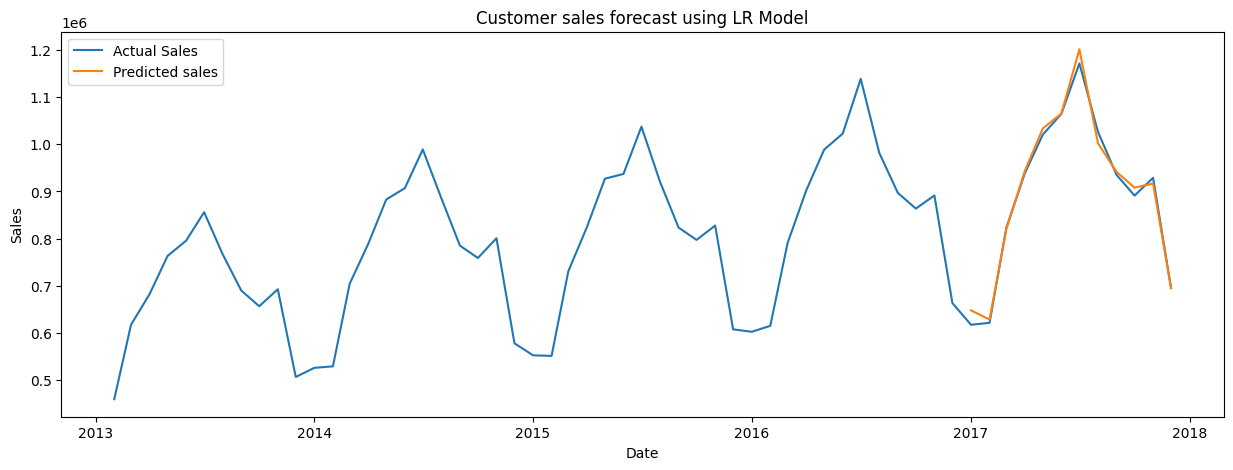

In [135]:
# Visualization of prediction against actual sales
plt.figure(figsize=(15,5))
# actual sales
plt.plot(monthly_sales['date'],monthly_sales['sales'])
# predicted sales
plt.plot(predict_df['date'],predict_df['Linear Prediction'])
plt.title("Customer sales forecast using LR Model")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend(['Actual Sales','Predicted sales'])
plt.show()